In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error



data_set = pd.read_csv('/Users/shenghaoisyummy/Capstone/feature_extraction_data_dummis_del_outlier_4000.csv', index_col=0)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
list(data_set)
data_set.head()
def time_to_total_minutes(df):
    df['target_minitues'] = df['arrv_late_time']/60

time_to_total_minutes(data_set)

In [3]:
data_Y = data_set[['target_minitues']]
data_set.drop(['actual_station_arrv_time_hours','actual_station_arrv_time_minutes', 'arrv_late_time', 'dprt_late_time', 'actual_station_dprt_time_hours', 'actual_station_dprt_time_minutes', 'target_minitues'], axis=1, inplace=True)


In [4]:
data_X = VarianceThreshold(threshold=3).fit_transform(data_set)

In [5]:
data_Y

,target_minitues
1,-1.0
2,-1.0
3,-1.0
4,-2.0
5,-1.0
6,-1.0
7,-1.0
8,-1.0
9,-1.0
10,-2.0


In [6]:
# make sure value as float
data_X_values = data_X
data_X_values = data_X_values.astype('float32')

data_Y_values = data_Y.values
data_Y_values = data_Y_values.astype('float32')
# normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
data_X_values = scaler.fit_transform(data_X_values)
data_Y_values = scaler.fit_transform(data_Y_values)
# split train test
train_X, test_X, train_y, test_y = train_test_split(data_X_values, data_Y_values, test_size = 0.2, random_state = 4)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# get the dimension
input_data_features = train_X.shape[2] * 2

In [7]:
model = Sequential()

Train on 15999 samples, validate on 4000 samples
Epoch 1/15
 - 193s - loss: 0.0261 - val_loss: 0.0222
Epoch 2/15
 - 189s - loss: 0.0224 - val_loss: 0.0212
Epoch 3/15
 - 184s - loss: 0.0216 - val_loss: 0.0197
Epoch 4/15
 - 195s - loss: 0.0213 - val_loss: 0.0195
Epoch 5/15
 - 185s - loss: 0.0210 - val_loss: 0.0195
Epoch 6/15
 - 184s - loss: 0.0208 - val_loss: 0.0192
Epoch 7/15
 - 192s - loss: 0.0207 - val_loss: 0.0191
Epoch 8/15
 - 193s - loss: 0.0206 - val_loss: 0.0192
Epoch 9/15
 - 191s - loss: 0.0205 - val_loss: 0.0191
Epoch 10/15
 - 197s - loss: 0.0204 - val_loss: 0.0190
Epoch 11/15
 - 185s - loss: 0.0204 - val_loss: 0.0190
Epoch 12/15
 - 185s - loss: 0.0203 - val_loss: 0.0188
Epoch 13/15
 - 186s - loss: 0.0202 - val_loss: 0.0191
Epoch 14/15
 - 193s - loss: 0.0201 - val_loss: 0.0188
Epoch 15/15
 - 193s - loss: 0.0201 - val_loss: 0.0187


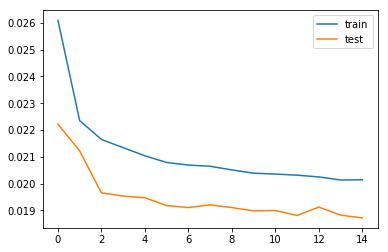

Test RMSE: 2.887


In [8]:

model.add(LSTM(input_data_features,  dropout=0, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=15, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)